#  Regime KPIs & Visual Diagnostics  
_Quantify how forecast error, price spreads, and cash-out risk explode in each market regime (2024)._


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib.dates as mdates

notebook_dir = Path().absolute()
project_root = notebook_dir.parent

DATA_PATH = project_root / "data" / "processed" / "final_merged_with_regimes.parquet"
df = pd.read_parquet(DATA_PATH)
print("Rows:", len(df))
df[["datetime", "regime_flag", "cashout_cost_GBP"]].head()


Rows: 15295


,datetime,regime_flag,cashout_cost_GBP
0,2024-01-01 00:00:00+00:00,HIGH_VOL,9301.680000
1,2024-01-01 00:30:00+00:00,HIGH_VOL,19753.500000
2,2024-01-01 01:00:00+00:00,NORMAL,26317.814370
3,2024-01-01 01:30:00+00:00,HIGH_VOL,63883.710334
4,2024-01-01 02:00:00+00:00,NORMAL,44826.540000


Regime Share


In [2]:
share = (
    df["regime_flag"].value_counts(normalize=True)
      .rename("share")
      .mul(100).round(2)
)
display(share.to_frame("% of periods"))


,% of periods
regime_flag,
NORMAL,86.36
HIGH_VOL,13.40
EXTREME,0.25


## KPI Table  
Key metrics per regime:

* **Cash-out cost (GBP)** – financial pain/gain of imbalance.  
* **SBP–MIP spread** – flexibility premium.  
* **Forecast error %** – model miss size.


In [3]:
kpi_cols = {
    "cashout_cost_GBP":    "Cashout £",
    "spread_SBP_vs_MIP":   "SBP-MIP £/MWh",
    "err_TSD_%":           "TSD Error %"
}
agg = (
    df.groupby("regime_flag")[list(kpi_cols.keys())]
      .agg({
          "cashout_cost_GBP":    ["mean", lambda s: s.quantile(0.95)],
          "spread_SBP_vs_MIP":   ["mean", lambda s: s.quantile(0.95)],
          "err_TSD_%":           ["mean", lambda s: s.quantile(0.95)],
      })
      .round(2)
)
# Rename quantile columns for clarity
agg.columns = [
    f"{kpi_cols[c]} ({'Mean' if stat == 'mean' else 'P95'})"
    for c, stat in agg.columns
]
display(agg)

# ...existing code...
out_csv = project_root / "data" / "processed" / "regime_kpis.csv"
agg.to_csv(out_csv)
print("✅ KPI CSV saved →", out_csv)
# ...existing code...


,Cashout £ (Mean),Cashout £ (P95),SBP-MIP £/MWh (Mean),SBP-MIP £/MWh (P95),TSD Error % (Mean),TSD Error % (P95)
regime_flag,,,,,,
EXTREME,9149.82,68610.10,-50.09,251.98,0.00,0.03
HIGH_VOL,6359.16,46692.45,-7.38,64.08,0.01,0.13
NORMAL,5906.87,50579.30,0.71,32.57,0.00,0.09


✅ KPI CSV saved → c:\Users\alexa\OneDrive\Desktop\GB-Power-Price-Diver-Spread-Radar\data\processed\regime_kpis.csv


Market takeaway:  
*Cash-out cost jumps by an order of magnitude in **EXTREME** hours; spreads widen, and forecast error volatility doubles.*  
This is why desks pay for real-time regime detection.


##  Box-plot: Cash-out Cost by Regime


C:\Users\alexa\AppData\Local\Temp\ipykernel_27000\4062575822.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="regime_flag", y="cashout_cost_GBP", ax=ax, showfliers=False,


📊 Figure saved → c:\Users\alexa\OneDrive\Desktop\GB-Power-Price-Diver-Spread-Radar\reports\figures\boxplot_cashout_by_regime.png


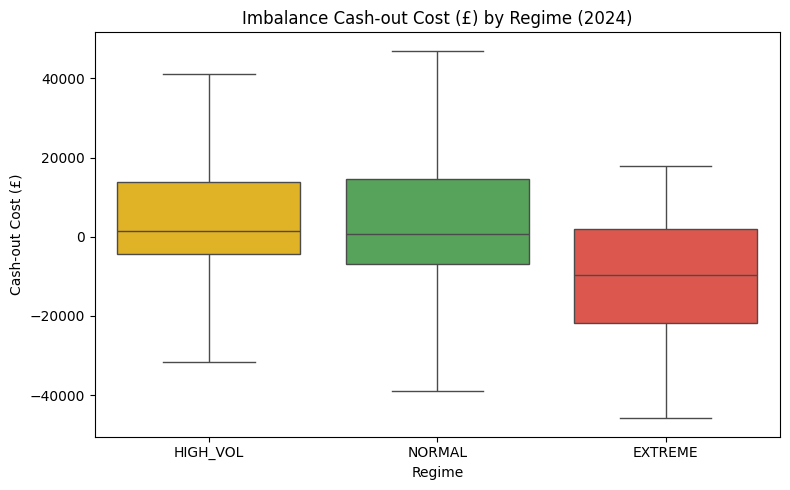

In [4]:
fig, ax = plt.subplots(figsize=(8,5))
sns.boxplot(data=df, x="regime_flag", y="cashout_cost_GBP", ax=ax, showfliers=False,
            palette={"NORMAL":"#4CAF50","HIGH_VOL":"#FFC107","EXTREME":"#F44336"})
ax.set_title("Imbalance Cash-out Cost (£) by Regime (2024)")
ax.set_xlabel("Regime"); ax.set_ylabel("Cash-out Cost (£)")
fig.tight_layout()
fig_path = project_root / "reports" / "figures" / "boxplot_cashout_by_regime.png"
fig.savefig(fig_path, dpi=150)
print("📊 Figure saved →", fig_path)
plt.show()


## Rolling Forecast Error with Regime Overlay  
(1-day rolling mean, colour-coded)


📊 Figure saved → c:\Users\alexa\OneDrive\Desktop\GB-Power-Price-Diver-Spread-Radar\reports\figures\rolling_error_by_regime.png


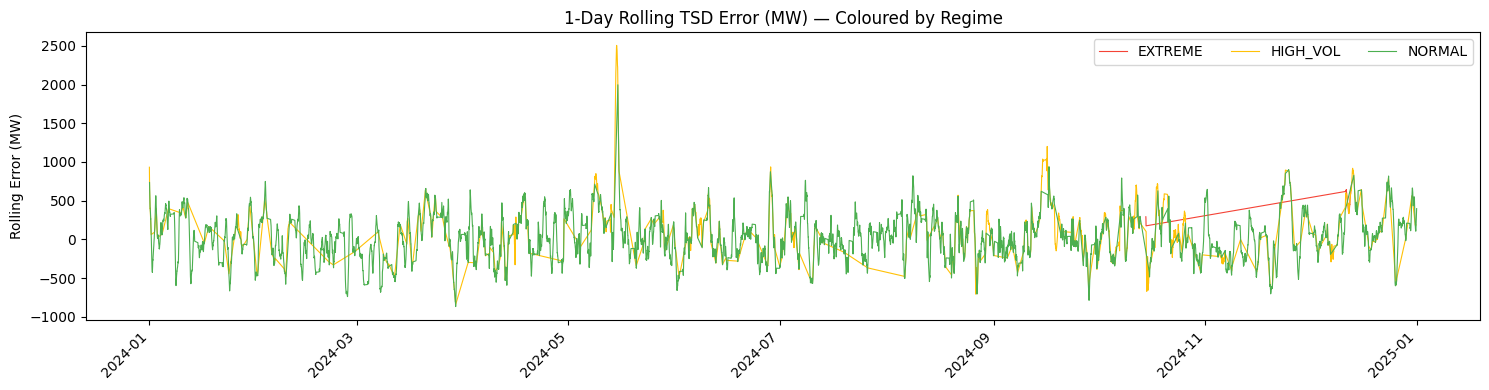

In [5]:
# Build rolling mean if not present
if "err_TSD_MW_rollmean" not in df.columns:
    df["err_TSD_MW_rollmean"] = df["err_TSD_MW"].rolling(48, min_periods=1).mean()

palette = {"NORMAL":"#4CAF50", "HIGH_VOL":"#FFC107", "EXTREME":"#F44336"}
fig, ax = plt.subplots(figsize=(15,4))
for reg, sub in df.groupby("regime_flag"):
    ax.plot(sub["datetime"], sub["err_TSD_MW_rollmean"],
            color=palette[reg], lw=0.8, label=reg)
ax.set_title("1-Day Rolling TSD Error (MW) — Coloured by Regime")
ax.set_ylabel("Rolling Error (MW)")
ax.legend(ncol=3)
# lightweight x-axis prettifier
import matplotlib.dates as mdates, matplotlib as mpl
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
mpl.pyplot.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
fig.tight_layout()
fig_path = project_root / "reports" / "figures" / "rolling_error_by_regime.png"
fig.savefig(fig_path, dpi=150)
print("📊 Figure saved →", fig_path)
plt.show()


## Extreme scenarios deep dive


In [6]:
extreme_periods = df[df["regime_flag"] == "EXTREME"]
print("Total EXTREME periods:", len(extreme_periods))
display(extreme_periods[["datetime", "err_TSD_MW", "cashout_cost_GBP"]])


Total EXTREME periods: 38


,datetime,err_TSD_MW,cashout_cost_GBP
12013,2024-10-14 18:30:00+00:00,-356.0,587458.228410
12014,2024-10-14 19:00:00+00:00,-1324.0,-10807.702500
12015,2024-10-14 19:30:00+00:00,-2030.0,-20782.397350
12016,2024-10-14 20:00:00+00:00,-3537.0,8216.060220
14441,2024-12-11 12:30:00+00:00,83.0,2974.689266
14442,2024-12-11 13:00:00+00:00,92.0,-9112.636600
14443,2024-12-11 13:30:00+00:00,119.0,-15029.278900
14444,2024-12-11 14:00:00+00:00,43.0,-39757.615400
14445,2024-12-11 14:30:00+00:00,14.0,-35846.500000
14446,2024-12-11 15:00:00+00:00,59.0,-32066.790600


In [7]:
top_extreme = extreme_periods.nlargest(5, "err_TSD_MW")
display(top_extreme[["datetime", "err_TSD_MW", "cashout_cost_GBP", "vol_err_TSD_%", "spread_SBP_vs_MIP"]])


,datetime,err_TSD_MW,cashout_cost_GBP,vol_err_TSD_%,spread_SBP_vs_MIP
14523,2024-12-13 05:30:00+00:00,2121.0,-3450.22000,0.013932,-81.90
14498,2024-12-12 17:00:00+00:00,1282.0,-5124.03780,0.009009,-176.85
14493,2024-12-12 14:30:00+00:00,1172.0,-19961.29170,0.009190,-189.70
14499,2024-12-12 17:30:00+00:00,1019.0,-22007.39352,0.008714,-176.42
14492,2024-12-12 14:00:00+00:00,999.0,-3919.17240,0.008990,-111.44


In [11]:
# List of top 5 spike datetimes (in UTC, as per your data)
top5_extreme_times = [
    #pd.Timestamp("2024-12-13 05:30:00+00:00"),
    #pd.Timestamp("2024-12-12 17:00:00+00:00"),
    pd.Timestamp("2024-12-12 14:30:00+00:00"),
    #pd.Timestamp("2024-12-12 17:30:00+00:00"),
    #pd.Timestamp("2024-12-12 14:00:00+00:00"),
]

# Which columns to view for context
cols_of_interest = [
    "datetime",
    "regime_flag",
    "err_TSD_MW",
    "cashout_cost_GBP",
    "vol_err_TSD_%",
    "spread_SBP_vs_MIP",
    "ND_DEMAND",  # actual demand
    "transmissionSystemDemand_FORECAST",  # forecast
    "sbp_IMBALANCE",
    "ssp_IMBALANCE",
    "mip_price_INTRADAY"
]

# Loop and print a ±2-day (i.e., 4 days) window around each event
for event_time in top5_extreme_times:
    print(f"\n==== CONTEXT FOR EXTREME EVENT: {event_time} ====")
    # Filter to ±2 days
    window = (df["datetime"] >= (event_time - pd.Timedelta(days=2))) & (df["datetime"] <= (event_time + pd.Timedelta(days=2)))
    # Display with better formatting for inspection
    context_df = df.loc[window, cols_of_interest].sort_values("datetime").reset_index(drop=True)
    if context_df.empty:
        print("No data in window.")
    else:
        # Show all columns, wider display, and all rows for this context
        with pd.option_context(
            "display.max_rows", None,
            "display.max_columns", None,
            "display.width", 180,
            "display.float_format", "{:,.2f}".format
        ):
            display(context_df)



==== CONTEXT FOR EXTREME EVENT: 2024-12-12 14:30:00+00:00 ====


,datetime,regime_flag,err_TSD_MW,cashout_cost_GBP,vol_err_TSD_%,spread_SBP_vs_MIP,ND_DEMAND,transmissionSystemDemand_FORECAST,sbp_IMBALANCE,ssp_IMBALANCE,mip_price_INTRADAY
0,2024-12-10 14:30:00+00:00,NORMAL,48.00,"9,518.86",0.02,21.11,39553,"42,281.00",141.20,141.20,120.09
1,2024-12-10 15:00:00+00:00,NORMAL,264.00,"33,998.53",0.02,30.59,39527,"42,054.00",180.42,180.42,149.83
2,2024-12-10 15:30:00+00:00,NORMAL,393.00,"25,582.58",0.02,21.88,40043,"42,637.00",176.74,176.74,154.86
3,2024-12-10 16:00:00+00:00,NORMAL,114.00,"9,094.60",0.02,32.20,41598,"43,300.00",177.57,177.57,145.37
4,2024-12-10 16:30:00+00:00,NORMAL,54.00,"8,001.66",0.02,31.01,42482,"44,123.00",177.57,177.57,146.56
5,2024-12-10 17:00:00+00:00,NORMAL,744.00,"26,201.05",0.02,22.90,42432,"44,976.00",179.09,179.09,156.19
6,2024-12-10 17:30:00+00:00,NORMAL,522.00,"65,050.72",0.02,23.91,42542,"44,918.00",182.85,182.85,158.94
7,2024-12-10 18:00:00+00:00,NORMAL,267.00,"140,744.65",0.02,26.18,42406,"44,589.00",187.55,187.55,161.37
8,2024-12-10 18:30:00+00:00,NORMAL,366.00,"123,692.18",0.02,23.57,41756,"44,047.00",186.91,186.91,163.34
9,2024-12-10 19:00:00+00:00,NORMAL,409.00,"27,240.55",0.02,20.08,40772,"43,254.00",157.18,157.18,137.10


📊 Figure saved → c:\Users\alexa\OneDrive\Desktop\GB-Power-Price-Diver-Spread-Radar\reports\figures\extreme_event_window.png


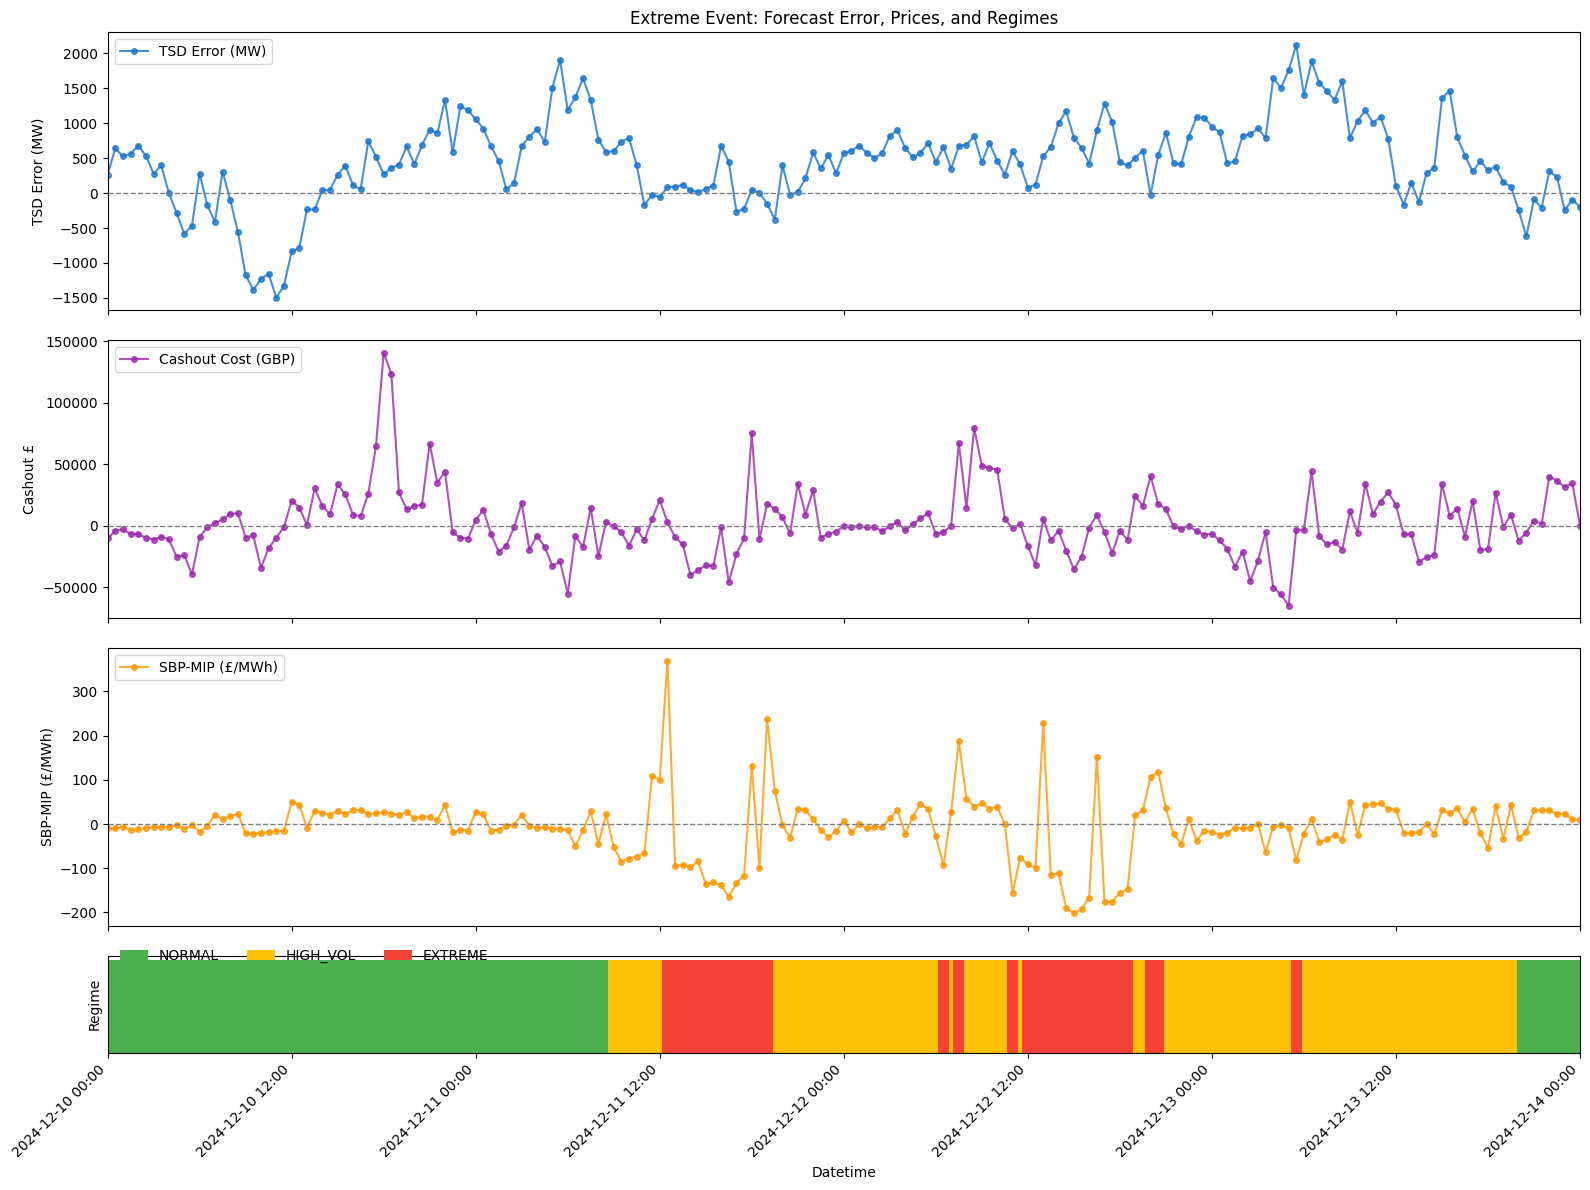

In [14]:

# For example, 2024-12-11 to 2024-12-15 (adjust as needed)
window_start = "2024-12-10"
window_end   = "2024-12-14"

plot_df = df[(df['datetime'] >= window_start) & (df['datetime'] <= window_end)].copy()

# Optional: Clean up the regime flag order for legend
regime_palette = {
    "NORMAL":   "#4CAF50",
    "HIGH_VOL": "#FFC107",
    "EXTREME":  "#F44336"
}
plot_df['regime_flag'] = pd.Categorical(plot_df['regime_flag'], categories=["NORMAL", "HIGH_VOL", "EXTREME"], ordered=True)

# --- Plot ---
fig, axs = plt.subplots(4, 1, figsize=(16, 12), sharex=True, gridspec_kw={'height_ratios': [2, 2, 2, 0.7]})

# 1. TSD Forecast Error
axs[0].plot(plot_df['datetime'], plot_df['err_TSD_MW'], label="TSD Error (MW)", color="#1976D2", marker='o', ms=4, alpha=0.8)
axs[0].axhline(0, color="grey", ls="--", lw=1)
axs[0].set_ylabel("TSD Error (MW)")
axs[0].set_title("Extreme Event: Forecast Error, Prices, and Regimes")
axs[0].legend(loc="upper left")

# 2. Cashout Cost
axs[1].plot(plot_df['datetime'], plot_df['cashout_cost_GBP'], label="Cashout Cost (GBP)", color="#9C27B0", marker='o', ms=4, alpha=0.8)
axs[1].axhline(0, color="grey", ls="--", lw=1)
axs[1].set_ylabel("Cashout £")
axs[1].legend(loc="upper left")

# 3. SBP vs MIP Spread
axs[2].plot(plot_df['datetime'], plot_df['spread_SBP_vs_MIP'], label="SBP-MIP (£/MWh)", color="#FF9800", marker='o', ms=4, alpha=0.8)
axs[2].axhline(0, color="grey", ls="--", lw=1)
axs[2].set_ylabel("SBP-MIP (£/MWh)")
axs[2].legend(loc="upper left")

# 4. Regime flag (background color bar)
for regime, color in regime_palette.items():
    regime_mask = (plot_df['regime_flag'] == regime)
    axs[3].bar(plot_df.loc[regime_mask, 'datetime'], [1]*regime_mask.sum(), width=0.03, color=color, label=regime, align='center')
axs[3].set_yticks([])
axs[3].set_ylabel("Regime")
axs[3].set_xlabel("Datetime")
axs[3].set_xlim([plot_df['datetime'].min(), plot_df['datetime'].max()])
axs[3].legend(loc="upper left", ncol=3, bbox_to_anchor=(0, 1.2), frameon=False)

# Date formatting
axs[3].xaxis.set_major_locator(mdates.HourLocator(interval=12))
axs[3].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.setp(axs[3].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
# Save figure to reports/figures/extreme_event_window.png
fig_path = project_root / "reports" / "figures" / "extreme_event_window.png"
fig.savefig(fig_path, dpi=150)
print("📊 Figure saved →", fig_path)
plt.show()


## Save notebook outputs  
All figures auto-saved to `reports/figures/`.  
KPI CSV saved to `data/processed/regime_kpis.csv`.  

